In [1]:
import numpy as np
import pandas as pd
import glob
import os
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.table import Table
import itertools
from astroquery.simbad import Simbad
from utils import PLOT_PARAMS
from astropy import constants as const
from matplotlib import colors
PLOT_PARAMS()
import thejoker as tj
import random
random.seed(42) 


from datetime import date
today=date.today()
DATE =today.strftime("%m_%d_%y")
print(DATE)
import pickle
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors

plt.rcParams['figure.facecolor'] = 'white'
import warnings
warnings.filterwarnings("ignore")
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
import astropy.units as u

vlt = EarthLocation.of_site('paranal')  # the easiest way... but requires internet

09_02_25


In [2]:
df_rich = pd.read_pickle('../../lithium/data/gfinal_rich.pkl')

In [3]:
galah = Table.read('../../lithium/data/GALAH_DR3_main_allstar_v2.fits').to_pandas()

In [4]:
galah_vac = Table.read('../../lithium/data/GALAH_DR3_VAC_ages_v2.fits').to_pandas()

In [5]:
rv_df = pd.read_csv('rv_df.csv')

In [6]:
comb_df = pd.read_csv('combined_rvs.csv')


In [7]:
binary_list_113 = [9, 11, 16, 18, 19, 23,] # old: 1, 4, 5, 7, 9, 11, 16, 18, 19, 21, 23  
binary_list_112 = [6, 7, 23] #old: 5, 6, 7, 23 #13 removed because of dipper star

In [8]:
def load_samples(df0,program,binary_list):
    stat_dict = {}        
    version = 1
    
    df = df0[df0.program==program]
    
    dtemp = {'RG_id':[],
             'P16':[], 'P50':[], 'P84':[],
             'e16':[], 'e50':[], 'e84':[],
             'K16':[], 'K50':[], 'K84':[] }
    
    for i, row in df.iterrows():
        RG = row.RG_id
        print(RG)
        
        if RG not in binary_list:
            continue
        fname = '../joker_samples/%s_%s_mcmc_%s.pickle'%(program,RG,version)
        
        with open(fname, 'rb') as handle:
            mcmc_samples = pickle.load(handle)
        
        if mcmc_samples == -999:
            Ps, es, Ks = np.nan, np.nan, np.nan
            dtemp['P16'].append(np.nan)
            dtemp['P50'].append(np.nan)
            dtemp['P84'].append(np.nan)
            dtemp['e16'].append(np.nan)
            dtemp['e50'].append(np.nan)
            dtemp['e84'].append(np.nan)

            dtemp['K16'].append(np.nan)
            dtemp['K50'].append(np.nan)
            dtemp['K84'].append(np.nan)

        else:
            Ps = mcmc_samples['P'].value
            es = mcmc_samples['e'].value
            Ks = mcmc_samples['K'].value

            dtemp['P16'].append(np.percentile(Ps, 16))
            dtemp['P50'].append(np.percentile(Ps, 50))
            dtemp['P84'].append(np.percentile(Ps, 84))

            dtemp['e16'].append(np.percentile(es, 16))
            dtemp['e50'].append(np.percentile(es, 50))
            dtemp['e84'].append(np.percentile(es, 84))

            dtemp['K16'].append(np.percentile(Ks, 16))
            dtemp['K50'].append(np.percentile(Ks, 50))
            dtemp['K84'].append(np.percentile(Ks, 84))
            
        dtemp['RG_id'].append(RG)

    dtemp = pd.DataFrame(dtemp)
    
    dtemp = pd.merge(dtemp, df)
    
    return dtemp

temp1 = load_samples(rv_df, 112, binary_list_112)
temp2 = load_samples(rv_df, 113, binary_list_113)


1
2
4
5
6
7
14
23
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


In [9]:
table1 = pd.concat([temp1, temp2])

# get mass from galah
table1 = pd.merge(table1, galah_vac[['sobject_id','m_act_bstep','e_m_act_bstep','radius_bstep','e_radius_bstep']], left_on='sobject_id', right_on='sobject_id')

table1.loc[(table1.RG_id==13) & (table1.program==112),'m_act_bstep']    = 1.070 #from Gaia DR3 FLAME
table1.loc[(table1.RG_id==13) & (table1.program==112),'radius_bstep']   = 2.0731 #from Gaia DR3 FLAME
table1.loc[(table1.RG_id==13) & (table1.program==112),'e_m_act_bstep']  = 0.04 #from Gaia DR3 FLAME
table1.loc[(table1.RG_id==13) & (table1.program==112),'e_radius_bstep'] = 0.05 #from Gaia DR3 FLAME

# table1.loc[table1.sobject_id==190212001601338,'m_act_bstep']    = 1.070 #from Gaia DR3 FLAME
# table1.loc[table1.sobject_id==190212001601338,'radius_bstep']   = 2.0731 #from Gaia DR3 FLAME
# table1.loc[table1.sobject_id==190212001601338,'e_m_act_bstep']  = 0.04 #from Gaia DR3 FLAME
# table1.loc[table1.sobject_id==190212001601338,'e_radius_bstep'] = 0.05 #from Gaia DR3 FLAME




In [10]:
def semi_major_axis(M1, M2, P):
    '''
    M1 : in solar masses
    P : in days
    M2 : in Mjup
    
    @return a: m
    
    '''
    G = const.G
    M1 = (M1*u.Msun).to(u.kg)
    M2 = (M2*u.Mjup).to(u.kg)
    M = (M1+M2)
    P = (P*u.day).to(u.second)
    a = (G*M*P**2/(4*np.pi**2))**(1./3)
    
    return a


In [11]:
def v_max(df):
    '''
    M1 in solar units
    M2 in Mjup units
    a in AU
    
    return v_max in km/s
    
    '''
    M1, M2 = df.m_act_bstep.to_numpy(), df.Mj50.to_numpy()
    a, e = df.a50.to_numpy(), df.e50.to_numpy()
    
    M1 = (M1*u.Msun).to(u.kg)
    M2 = (M2*u.Mjup).to(u.kg)
    M = (M1+M2)
    a = (a*u.au).to(u.m)
    M = (M1+M2)
    G = const.G

    v = ((G*M/a) * (2./(1-e) - 1))
    v = [np.sqrt(i.value) for i in v]
    v = [(i*u.m/u.s).to(u.km/u.s).value for i in v]
    
    df['v_max'] = v
    
    return df

In [12]:

def v_orb(df):
    '''
    a: in meters
    P: in days
    
    v_orb : in km/s
    
    '''
    a, P = df.a50.to_numpy(), df.P50.to_numpy()
    
    a = (a*u.au).to(u.m)
    P = (P*u.day).to(u.second)

    v = 2*np.pi*a/P
    v = [i.to(u.km/u.s).value for i in v]
    df['v_orb'] = v
    return df


In [13]:
def msini_func(K, P, e, Mstar):
    '''
    Get Mp sin(i), the minimum mass of the companion.
    @input:
        K: semi-amplitude in km/s
        P: period in days
        e: eccentricity
        M: mass of the star in solar masses
    
    @return:
        Msini: Msini in kg
    '''
    from scipy import optimize
    # define constants
    pi = np.pi
    G  = const.G
    
    # convert units to SI units
    K = abs((K*(u.km/u.second)).to(u.meter/u.second))
    P = (P*u.day).to(u.second)
    Mstar = (Mstar*u.M_sun).to(u.kg)
    e = e*u.dimensionless_unscaled
    
    # if Mp << Mstar:
    # Msini = (Mstar)**(2./3.) * np.sqrt(1-e**2.) * K * (P/(2*pi*G))**(1./3.)
    
    # else:
    a     = np.sqrt(1-e**2.) * K * (P/(2*pi*G))**(1./3.)
    
    def func(x, a, Mstar):
        return x - (Mstar + x)**(2./3.) * a # x = Msini

    initial_guess = 0.1*u.Msun.to(u.kg)
    
    sol   = optimize.root(func, initial_guess, args=(a.value, Mstar.value) )
    Msini = sol.x
    
    #root  = brentq(func, 0.1, Msun , args=(a.value, Mstar.value))
    
    return Msini, sol.success


In [14]:
def clean_up(df):
    galah_id = df.sobject_id.values[0]
    dtemp    = comb_df[comb_df.GALAH_ID==galah_id]
    
    time = dtemp['time'].to_numpy()
    rv   = dtemp['rv'].to_numpy()
    err  = dtemp['rv_err'].to_numpy()
    source  = dtemp['source'].to_numpy()
    
    
    return time, rv, err, source, dtemp

clean_up(rv_df[(rv_df.RG_id==1) & (rv_df.program==112)])


(array([2460341.53519178, 2460389.56581584, 2460371.51348333,
        2460303.84853621, 2457030.1328125 ]),
 array([53.7010931 , 53.79850384, 53.71577284, 53.45877222, 53.55199814]),
 array([0.03563532, 0.0194216 , 0.01884311, 0.00615718, 0.072     ]),
 array(['ESPRESSO', 'ESPRESSO', 'ESPRESSO', 'ESPRESSO', 'GALAH'],
       dtype=object),
            GALAH_ID          time         rv    rv_err    source
 24  150107004201104  2.460342e+06  53.701093  0.035635  ESPRESSO
 25  150107004201104  2.460390e+06  53.798504  0.019422  ESPRESSO
 26  150107004201104  2.460372e+06  53.715773  0.018843  ESPRESSO
 27  150107004201104  2.460304e+06  53.458772  0.006157  ESPRESSO
 28  150107004201104  2.457030e+06  53.551998  0.072000     GALAH)

In [15]:
def get_msini(df0,program,binary_list):
    version = 1
    df = df0[df0.program==program]

    dtemp = {'RG_id':[], 'Mj16':[], 'Mj50':[], 'Mj84':[], 
             'a16': [], 'a50':[], 'a84':[]
            }
    for i, row in df.iterrows():
        RG = row.RG_id
        
        if RG not in binary_list:
            continue
        fname = '../mcmc/%s_%s_mcmc_%s.pickle'%(program,RG,version)

        with open(fname, 'rb') as handle:
            mcmc_samples = pickle.load(handle)

        Ks = mcmc_samples['K'].value
        Ps = mcmc_samples['P'].value
        es = mcmc_samples['e'].value
        
        Mstar_val  = np.array(df[(df.RG_id==RG)].m_act_bstep)[0]
        eMstar_val = np.array(df[(df.RG_id==RG)].e_m_act_bstep)[0]
        
        if str(Mstar_val) == 'nan':
            if df.sobject_id.values[0] == 190212001601338: # gaia DR3 3217773074208416640
                Mstar_val = 1.070
               
        Mjup = np.empty(len(Ks))
        a_au = np.empty(len(Ks))
        
        Mstar_samples = np.random.normal(Mstar_val, eMstar_val, size=len(Ks))
        
        for i in range(len(Ks)):
            K, P, e, Mstar = Ks[i], Ps[i], es[i], Mstar_samples[i]
            Msini, success = msini_func(K, P, e, Mstar)
            Msini_jup   = Msini/u.M_jup.to(u.kg)
            Mjup[i] = Msini_jup[0]
            
            a_m  = semi_major_axis(M1=Mstar, M2=Msini_jup, P=P)

            a_au[i] = a_m.to(u.au).value
        
        dtemp['RG_id'].append(RG)
        
        dtemp['Mj16'].append(np.percentile(Mjup, 16))
        dtemp['Mj50'].append(np.percentile(Mjup, 50))
        dtemp['Mj84'].append(np.percentile(Mjup, 84))
        
        dtemp['a16'].append(np.percentile(a_au, 16))
        dtemp['a50'].append(np.percentile(a_au, 50))
        dtemp['a84'].append(np.percentile(a_au, 84))

    dtemp = pd.DataFrame(dtemp)
    dtemp = pd.merge(dtemp, df)
    
    return dtemp

mass_temp1 = get_msini(table1, 112, binary_list_112)
mass_temp2 = get_msini(table1, 113, binary_list_113)

table2 = pd.concat([mass_temp1, mass_temp2])

In [16]:
table4 = table2.copy()

In [17]:
table4 = v_max(table4)
table4 = v_orb(table4)

table4.to_csv('table4.csv',index=False)

In [18]:
plt.rcParams['figure.facecolor'] = 'white'


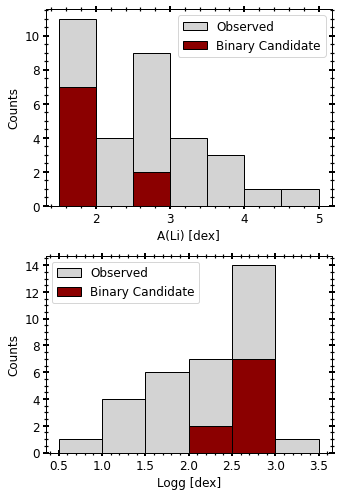

In [19]:
PLOT_PARAMS(LS=12,SIZE=12)
plt.figure(figsize=(5,7))
plt.subplot(211)
bins=np.arange(1.5, 5.5, 0.5)
d1 = rv_df[(rv_df.program==112) & (rv_df.RG_id.isin(binary_list_112))]#.Li_val.values
d2 = rv_df[(rv_df.program==113) & (rv_df.RG_id.isin(binary_list_113))]#.Li_val.values
both_galah = pd.concat([d1, d2])

plt.hist(rv_df.Li_val.values, bins=bins, label='Observed',color='lightgrey', ec='k')
# plt.hist(rv_df[(rv_df.program==112) & (rv_df.RG_id.isin(binary_list_112))].Li_val.values, bins=bins, label='Observed',color='lightgrey', ec='k')
plt.hist(both_galah.Li_val.values, bins=bins, label='Binary Candidate',color='darkred', ec='k')
plt.xlabel('A(Li) [dex]')
plt.ylabel('Counts')
plt.legend()

plt.subplot(212)
bins=np.arange(0.5, 4., 0.5)
d1 = rv_df[(rv_df.program==112) & (rv_df.RG_id.isin(binary_list_112))]#.Li_val.values
d2 = rv_df[(rv_df.program==113) & (rv_df.RG_id.isin(binary_list_113))]#.Li_val.values
both_galah = pd.concat([d1, d2])

plt.hist(rv_df.logg.values, bins=bins, label='Observed',color='lightgrey', ec='k')
# plt.hist(rv_df[(rv_df.program==112) & (rv_df.RG_id.isin(binary_list_112))].Li_val.values, bins=bins, label='Observed',color='lightgrey', ec='k')
plt.hist(both_galah.logg.values, bins=bins, label='Binary Candidate',color='darkred', ec='k')
plt.xlabel('Logg [dex]')
plt.ylabel('Counts')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('../plots/binary_fraction_%s.png'%DATE,bbox_inches='tight',dpi=150)


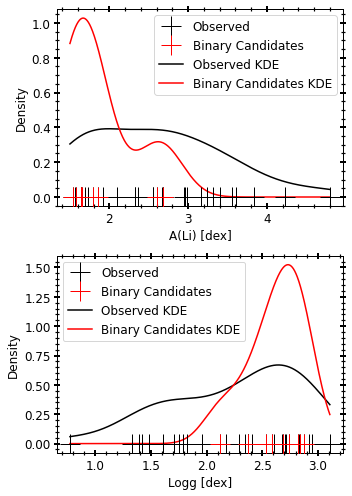

In [56]:
def make_kde():
    from scipy.stats import gaussian_kde
    
    # Li KDE
    x1 = rv_df.Li_val.values
    x2 = both_galah.Li_val.values

    kde1 = gaussian_kde(x1)
    kde2 = gaussian_kde(x2)
    x_eval = np.linspace(1.5, max(x1), num=1000)

    
    # PLOTTING
    PLOT_PARAMS(LS=12,SIZE=12)
    plt.figure(figsize=(5,7))
    plt.subplot(211)

    plt.plot(x1, np.zeros(x1.shape), '+', color='k', ms=20, label='Observed',zorder=100)  # rug plot
    plt.plot(x2, np.zeros(x2.shape), '+', color='r', ms=20, label='Binary Candidates',zorder=100)  # rug plot
    plt.plot(x_eval, kde1(x_eval), color='k',label='Observed KDE')
    plt.plot(x_eval, kde2(x_eval), color='r',label='Binary Candidates KDE')
    plt.xlabel('A(Li) [dex]')
    plt.ylabel('Density')
    plt.legend()
    
    # Logg KDE
    x1 = rv_df.logg.values
    x2 = both_galah.logg.values

    kde1 = gaussian_kde(x1)
    kde2 = gaussian_kde(x2)
    x_eval = np.linspace(min(x1), max(x1), num=1000)

    # PLOTTING
    plt.subplot(212)
    plt.plot(x1, np.zeros(x1.shape), '+', color='k', ms=20, label='Observed',zorder=100)  # rug plot
    plt.plot(x2, np.zeros(x2.shape), '+', color='r', ms=20, label='Binary Candidates',zorder=100)  # rug plot
    plt.plot(x_eval, kde1(x_eval), color='k',label='Observed KDE')
    plt.plot(x_eval, kde2(x_eval), color='r',label='Binary Candidates KDE')
    plt.xlabel('Logg [dex]')
    plt.ylabel('Density')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('../plots/binary_fraction_KDE_%s.png'%DATE,bbox_inches='tight',dpi=150)

make_kde()

In [115]:
def get_prob(n, r, p):
    '''Bernoulli trials
    n : trials
    r : success
    p : probability
    '''
    from math import comb
    
    q = 1.-p
    
    nchooser = comb(n, r)
    result = nchooser * p**r * q**(n-r)
    return result

bin1 = get_prob(n=11, r=7, p=9./33)
bin2 = get_prob(n=4, r=0, p=9./33)
bin3 = get_prob(n=9, r=2, p=9./33)


prob = 0
for i in range(0,7,1):
    r_0 = get_prob(n=33, r=i, p=9./33)
    #print(i, r_0)
    prob+=r_0

print('prob of getting r=0-6 out of 33 trials:',prob)
print('so prob of getting r>= 7 out of 33 trials:',1-prob)


# logg work:

logg_2to3    = get_prob(n=21, r=9, p=9./33)
logg_outside = get_prob(n=12, r=0, p=9./33) #outside of 2-3 range

prob = 0
for i in range(0,10,1):
    r_0 = get_prob(n=21, r=i, p=9./33)
    print(i, r_0)
    prob+=r_0

print('prob of getting r=0-8 out of 21 trials:',prob)
print('so prob of getting r>=9 out of 21 trials:',1-prob)



prob of getting r=0-6 out of 33 trials: 0.16441507197115557
so prob of getting r>= 7 out of 33 trials: 0.8355849280288444
0 0.0012463595292495733
1 0.009815081292840387
2 0.03680655484815145
3 0.08741556776435969
4 0.147513770602357
5 0.1880800575180051
6 0.1880800575180051
7 0.1511357605055398
8 0.09918284283176047
9 0.05372403986720359
prob of getting r=0-8 out of 21 trials: 0.9630000922774722
so prob of getting r>=9 out of 21 trials: 0.036999907722527814


In [ ]:

def peri_r(df):
    
    '''
    M1 : primary mass (ie. RG)
    M2 : companion mass
    R1 : primary radius (ie. RG)
    r  : periastron radius
    
    Dimensionless tidal amplitude parameter: 

    epsilon = (M_2/M_1)(R_1/r)^3

    Where R_1 is primary radius, 
    r is orbital separation (or distance at periastron), 
    M_2 is companion mass, M_1 is primary mass

    '''
    dfnew=df.copy()
    
    M1, M2 = df.m_act_bstep.to_numpy(), df.Mj50.to_numpy()
    a, e   = df.a50.to_numpy(), df.e50.to_numpy()
    R1     = df.radius_bstep.to_numpy()

    
    M1   = (M1*u.Msun).to(u.kg)
    M2   = (M2*u.Mjup).to(u.kg)
    a_au = (a*u.au)
    R1   = (R1*u.Rsun).to(u.au)
    r_p  = a_au*(1.-e)

    epsilon = (M2/M1)*(R1/r_p)**3.
    
    dfnew['epsilon'] = epsilon
    dfnew['rperi'] = r_p.value
    fig, ((ax1, ax2, ax3,ax4), (ax5,ax6,ax7, ax8)) = plt.subplots(2,4,figsize=(14,6))
    
    mask = (df.Mj50 <= 600) & (df.Mj50 >=83)
    mask = (df.Mj50 <= 80) & (df.Mj50 >=13)
    mask = (df.Mj50 <= 13)
    mask = (df.Mj50 >= 600)

    d2 = df[mask]
    print(min(d2.e50),max(d2.e50))
    print(np.sort(d2.vbroad))
    print(d2.logg.values)
    print(d2.a50.values)
    print(d2.P50.values)
    ax1.scatter(df.Li_val, df.logg)
    ax1.scatter(d2.Li_val, d2.logg)
    
    ax2.scatter(df.Li_val, df.Mj50)
    
    ax3.scatter(df.Li_val, df.a50)
    ax3.scatter(d2.Li_val, d2.a50)
    
    ax4.scatter(df.Li_val, df.radius_bstep)
    
    ax5.scatter(df.Li_val, df.e50)
    ax5.scatter(d2.Li_val, d2.e50)
    
    ax6.scatter(df.Li_val, df.a50*(1-df.e50))
    ax6.scatter(d2.Li_val, d2.a50*(1-d2.e50))
    
    ax7.scatter(df.Li_val, epsilon)#, c=df.logg)    
    ax7.scatter(d2.Li_val, epsilon[mask])
    #ax7.axvline(2.7)
    ax8.scatter(df.Li_val, df.fe_h)
    ax8.scatter(d2.Li_val, d2.fe_h)
    print(df.logg[mask].tolist())
    print(df.vbroad[mask].tolist())
    
    ax1.set_ylabel('Logg')
    ax2.set_ylabel('M-companion [Mj]')
    ax3.set_ylabel('Sep [au]')
    ax4.set_ylabel('R-star [solar]')
    ax5.set_ylabel('Eccentricity')
    ax6.set_ylabel('Periastron Radius [au]')
    ax7.set_ylabel('Epsilon')
    ax8.set_ylabel('FeH')
    
    ax1.invert_yaxis()
    ax2.set_yscale('log')
    ax7.set_yscale('log')
    
    for ax in [ax5,ax6,ax7,ax8]:
        ax.set_xlabel('A(Li) [dex]')
    
    formula = r'$\epsilon= \frac{M_2}{M_1} (\frac{R_1}{r_p} )^3$'
    
    ax7.text(0.5, 0.95, s=formula, transform=ax7.transAxes,fontsize=20, ha='center',va='top')
    
    for i,ax in zip('ABCDEFGH',[ax1,ax2,ax3,ax4,ax5,ax6,ax7, ax8]):
        ax.text(0.95, 0.95, s=i, transform=ax.transAxes,fontsize=20, ha='right',va='top')
        
    print(d2.fe_h.values)
    fig.tight_layout()
    plt.subplots_adjust(hspace=0)
#     plt.savefig('../plots/diagnostic_%s.png'%DATE,bbox_inches='tight',dpi=200)
    #return dfnew[['RG_id','program','m_act_bstep','radius_bstep','rperi','a50','e50','Mj50','epsilon','Li_val','logg']].sort_values(by=['logg'])

peri_r(table4)


In [ ]:
print('Eccentricity range:  %.3f-%.3f' % (min(table4.e50),max(table4.e50)))
print('Period range:  %.2f-%.2f' % (min(table4.P50),max(table4.P50)))
print('Separation range: %.2f-%.2f' % (min(table4.a50),max(table4.a50)))
print('Mstellar range:  %.2f-%.2f' % (min(table4.m_act_bstep),max(table4.m_act_bstep)))
print('FeH range:  %.2f-%.2f' % (min(table4.fe_h),max(table4.fe_h)))

table4[['fe_h','Mj50','m_act_bstep']].sort_values(by=['m_act_bstep'])


In [ ]:
table4.sort_values(by='Mj50')[['obj_name','program','RG_id','teff','Li_val','m_act_bstep','fe_h','logg','P50','e50','Mj50','vbroad']]#[table4.Mj50<100]

In [ ]:
def rv_variable(df, ax,binary=False):
    '''
    check how many out of 34 are RV variable: K>sigma_rv
    see adamow+2018 for details
    '''
    
    def calc_v_osc(L, M):
        '''
        Eq 7 in Kjeldsen & Bedding 1995
        @input: L & M in solar units
        
        @output: vosc in cm/s
        
        
        '''
        return (L/M) * 23.4 #cm/s
        
    def calc_lum(T, R):
        '''
        calculate luminosity
        @input: T in K, R in solar units
        '''
        return R**2.*(T/5777.)**4. 
        
    
    d1 = df.copy()
    all_vosc   = []
    all_K      = []
    all_rv_err = []
    for i,row in df.iterrows():
        dftemp = df[df.sobject_id==row.sobject_id]
        mass    = galah_vac[galah_vac.sobject_id==row.sobject_id].m_act_bstep.values[0]
        log_lum = galah_vac[galah_vac.sobject_id==row.sobject_id].log_lum_bstep.values[0]
        r_bstep = galah_vac[galah_vac.sobject_id==row.sobject_id].radius_bstep.values[0]
        lum     = 10.**log_lum
        _,rv_vals,rv_err,_,_ = clean_up(dftemp)
        K           = (np.max(rv_vals) - np.min(rv_vals))/2.
        v_osc       = (calc_v_osc(lum, mass)*u.cm/u.s).to(u.km/u.s).value
        mean_rv_err = np.mean(rv_err)
        #print('%.3f \t %.2f \t %.3f' %( v_osc, K, mean_rv_err ))
        if row.sobject_id== 170416004301008:
            print(lum,mass,lum/mass*23.4,(lum/mass*23.4)/1e5)
        # save
        all_vosc.append(v_osc)
        all_K.append(K)
        all_rv_err.append(mean_rv_err)
        
    d1['vosc'] = all_vosc
    d1['K_rv'] = all_K
    d1['mean_rv_err'] = all_rv_err
    
        #print(K,mean_rv_err)
    
    #ax1.scatter(d1.K_rv,d1.mean_rv_err)
#     np.log10(d1.K_rv*1000/d1.vosc)
    im=ax.scatter(d1.vosc,d1.K_rv,c=d1.vbroad,cmap='Reds',ec='grey',s=50)
    if binary:
        ax.scatter(d1.vosc,d1.K_rv,fc='None',ec='k',s=300,label='Binary Candidate')
    ax.legend(loc='lower right')
    line = np.linspace(min(d1.vosc),max(d1.vosc),1000)
    ax.plot(line, line, c='k', ls='dashed')
    
    print(np.sort(np.log10(d1.K_rv*1000/d1.vosc)))
    return im, d1
    
plt.figure(figsize=(5,4))
ax=plt.subplot(111) 
ax.set_ylabel('Half Peak-to-Peak [km/s]')

ax.set_xlabel(r'Oscillation Amplitude, $v_{\rm osc}$ [km/s]')
ax.set_xscale('log') 
ax.set_yscale('log') 
im,d1=rv_variable(rv_df,ax)

plt.colorbar(im,label=r'$v_{\rm broad}$ [km/s]')
_=rv_variable(table4,ax,binary=True)
plt.tight_layout()
plt.savefig('../plots/vosc_%s.png'%DATE,bbox_inches='tight',dpi=150)
plt.show()
# d1[['vosc','K_rv','sobject_id','program','RG_id']].sort_values(by=['vosc'])
d1[(d1.program==113) & (d1.RG_id==21) ][['vosc','vbroad']]

In [ ]:
# table4[(table4.program==113) & (table4.RG_id==21)][['P50','e50','K50']]

In [ ]:
def compare_adamow(df):
    '''
    compare our orbital parameters to Adamow 2014: 
    https://www.aanda.org/articles/aa/pdf/2018/05/aa32161-17.pdf
    '''
    
    d = {
        'TYC 0405-01700-1'  : {'M': 0.53*u.Msun.to(u.Mjup) , 'a': 0.220, 'e': 0.04},
        'TYC 3314-01371-1'  : {'M': 0.235*u.Msun.to(u.Mjup), 'a': 2.17, 'e': 0.3392 },
        'HD 181368'         : {'M': 220, 'a': 10.7 , 'e': 0.75},
        'BD+48 740'         : {'M': 1.7, 'a': 1.7  , 'e': 0.76},
        'HD 238914'         : {'M': 6,   'a': 5.7  , 'e': 0.56 },
        'TYC 3318-01333-1'  : {'M': 3.4, 'a': 1.4  , 'e': 0.1},
        'TYC 3663-01966-1'  : {'M': 1.3, 'a': 0.7  , 'e': 0.5} ,#maybe
        'TYC 3105-00152-1'  : {'M': 4.6, 'a': 1.92 , 'e': 0.78} #maybe   
    }
    
    ec1, fc1 = 'k', 'lightgrey'
    ec2, fc2 = 'k', '#FB6A4A'

    plt.figure(figsize=(5,8))
    PLOT_PARAMS(LS=14, SIZE=14)
    ax1=plt.subplot(211)
    plt.scatter(df.a50, df.e50, ec=ec1,fc=fc1)
    for k, v in d.items():
        if k in ['TYC 3663-01966-1','TYC 3105-00152-1' ]:
            plt.scatter(v['a'], v['e'],ec=ec2,fc=fc2,marker='s')
        else:
            plt.scatter(v['a'], v['e'],ec=ec2,fc=fc2,marker='o')

    ax2=plt.subplot(212)
    plt.scatter(df.a50, df.Mj50, ec=ec1,fc=fc1)
    for k, v in d.items():
        if k in ['TYC 3663-01966-1','TYC 3105-00152-1' ]:
            plt.scatter(v['a'], v['M'],ec=ec2,fc=fc2,marker='s')
        else:
            plt.scatter(v['a'], v['M'],ec=ec2,fc=fc2,marker='o')
    plt.yscale('log')
    ax2.set_xlabel('Separation [au]')
    ax2.set_ylabel('M$\sin i$, $M_J$')
    ax1.set_ylabel('Eccentricity')

    
    lgnd1 = [Line2D([0], [0], marker='o', label='This Work', mfc=fc1, mec=ec1, color='white',  lw=1), 
             Line2D([0], [0], marker='o', label='Adamòw+2018', mfc=fc2, mec=ec2, color='white',  lw=1), 
             Line2D([0], [0], marker='s', label='Possible Companions\nin Adamòw+2018', mfc=fc2, mec=ec2, color='white',  lw=1)]
    
    ax1.legend(handles=lgnd1,loc='lower right',fontsize=12)
    plt.savefig('../plots/adamow_%s.png'%DATE,bbox_inches='tight',dpi=200)
compare_adamow(table4)
    

In [ ]:
plt.figure(figsize=(5,4))
plt.scatter(table4.e50,table4.fe_h, )
plt.xlabel('Eccentricity')
plt.ylabel('FeH')
plt.axhline(-0.1, c='k',ls='dashed',lw=1)
plt.axhline(-0.4, c='k',ls='dashed',lw=1)
plt.axhline(0, c='k',ls='dashed',lw=1)
plt.axhline(0.7, c='k',ls='dashed',lw=1)
plt.tight_layout()
# plt.savefig('../plots/ecc_vs_feh_%s.png'%DATE,bbox_inches='tight',dpi=200)

In [ ]:
PLOT_PARAMS(LS=12,SIZE=12)
fig, ((ax1),(ax2)) = plt.subplots(2,1,figsize=(4,6))


ax1.scatter(rv_df.vbroad, rv_df.Li_val,ec='k',fc='grey',marker='s',label='ESPRESSO Targets',s=25)
mask_112 = (rv_df.RG_id.isin(binary_list_112) & (rv_df.program==112))
mask_113 = (rv_df.RG_id.isin(binary_list_113) & (rv_df.program==113))
ax1.scatter(rv_df[mask_112].vbroad, rv_df[mask_112].Li_val,ec='r',s=150,fc='None')
ax1.scatter(rv_df[mask_113].vbroad, rv_df[mask_113].Li_val,ec='r',s=150,fc='None',label='Binary Candidate')

ax1.set_xlabel('$\mathrm{v_{broad}}$ [km/s]')
ax1.set_ylabel('A(Li) [dex]')

ax2.scatter(rv_df.teff, rv_df.logg,ec='k',fc='grey',marker='s',label='ESPRESSO Targets',s=25)
ax2.scatter(rv_df[mask_112].teff, rv_df[mask_112].logg,ec='r',s=150,fc='None')
ax2.scatter(rv_df[mask_113].teff, rv_df[mask_113].logg,ec='r',s=150,fc='None',label='Binary Candidate')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
ax2.set_xlabel('Teff [K]')
ax2.set_ylabel('Logg [dex]')

ax1.grid(ls='dotted',c='grey')
ax2.grid(ls='dotted',c='grey')

lgnd=ax1.legend(fontsize=10)
lgnd.legend_handles[0]._sizes = [30]
lgnd.legend_handles[1]._sizes = [30]


def make_density_plot(x,y,nbins=100):
    from scipy.stats import gaussian_kde

    # Calculate the point density
    k = gaussian_kde([x,y])
    xi, yi = np.mgrid[
       x.min():x.max():nbins*1j,
       y.min():y.max():nbins*1j
    ]
    zi = k(np.vstack([xi.flatten(),yi.flatten()])).reshape(xi.shape)
    return xi,yi,zi

xi,yi,zi=make_density_plot(df_rich.vbroad, df_rich.fe_h+df_rich.Li_fe+1.05)
ax1.pcolormesh(xi, yi, zi,cmap='Reds',zorder=0)

xi,yi,zi=make_density_plot(df_rich.teff, df_rich.logg,)
ax2.pcolormesh(xi, yi, zi,cmap='Reds',zorder=0)

fig.tight_layout()
plt.savefig('../plots/hrd_%s.png'%DATE,bbox_inches='tight',dpi=200)

In [ ]:
print('\n')
print('# with logg < 2.5:',rv_df[rv_df.logg <= 2.5].sobject_id.count())
print('# with logg < 2.5 in 112:',rv_df[mask_112][rv_df[mask_112].logg <= 2.5].sobject_id.count())
print('# with logg < 2.5 in 113:',rv_df[mask_113][rv_df[mask_113].logg <= 2.5].sobject_id.count())
print('total:',7)

print('\n')
print('# with logg = 2.5-3.0:',rv_df[(rv_df.logg >= 2.5) & (rv_df.logg <= 3.0)].sobject_id.count())
print('# with logg = 2.5-3.0 in 112:',rv_df[mask_112][(rv_df[mask_112].logg >= 2.5) & (rv_df[mask_112].logg <= 3.0)].sobject_id.count())
print('# with logg = 2.5-3.0 in 113:',rv_df[mask_113][(rv_df[mask_113].logg >= 2.5) & (rv_df[mask_113].logg <= 3.0)].sobject_id.count())
print('total:',8)

print('\n')
print('# with logg > 3.0:',rv_df[rv_df.logg >= 3.0].sobject_id.count())

In [ ]:
table3 = table4.copy() #table4[~((table4.RG_id==23) & (table4.program==112))]


In [ ]:
def half_amp_plot(df):
    
    new_d = {'RG_id':[],'program':[], 'logg':[],'half_rv':[]}
    for i, row in df.iterrows():
        program, RG_id = row.program,row.RG_id
        dtemp = df[(df.program==program) & (df.RG_id==RG_id)]
        _,rv_vals,_,_,_ = clean_up(dtemp)
        half_rv  = (max(rv_vals)-min(rv_vals))/2.
        new_d['logg'].append(dtemp.logg.values[0])
        new_d['half_rv'].append(half_rv)
        new_d['program'].append(program)
        new_d['RG_id'].append(RG_id)
    new_d = pd.DataFrame(new_d)
    
    new_d1 = pd.merge(table3[table3.program==112], new_d[new_d.program==112],on='RG_id')
    new_d2 = pd.merge(table3[table3.program==113], new_d[new_d.program==113],on='RG_id')
    new_d1 = pd.concat([new_d1, new_d2])
    
    plt.figure(figsize=(5,4))
    ax=plt.subplot(111)
    
    bounds = [0,1,2,3,4]
    cmap_color = 'Reds'
    cmap = plt.get_cmap(cmap_color, len(bounds))
    norm = colors.BoundaryNorm(bounds, cmap.N)
    clabel = 'Separation [AU]'

    mask_112 = (new_d.RG_id.isin(binary_list_112) & (new_d.program==112))
    mask_113 = (new_d.RG_id.isin(binary_list_113) & (new_d.program==113))

    plt.scatter(new_d.logg, new_d.half_rv*1000,ec='None',fc='k',s=60)
    im=plt.scatter(new_d1.logg_x, new_d1.half_rv*1000,c=new_d1.a50,cmap=cmap, norm=norm,ec='grey',s=60)
    #plt.scatter(new_d[mask_112].logg, new_d[mask_112].half_rv*1000,ec='r',s=150,fc='None')
    #plt.scatter(new_d[mask_113].logg, new_d[mask_113].half_rv*1000,ec='r',s=150,fc='None',label='Binary Candidate')
    
    plt.yscale('log')
    plt.xlabel('Logg [dex]')
    plt.ylabel('Half Peak-to-Peak [m/s]')
    plt.xlim(0.5,3.5)
    
    plt.ylim(10,3e4)
    
    x = np.linspace(0,4,100)    

    def func1(logg):
        a, b = -0.60, 3.31
        log_v = a*logg+b
        return 10.**log_v
    
    def func2(logg):
        siga, sigb = 0.04, 0.10
        a, b = -0.60, 3.31
        a = a+3.5*siga
        b = b+3.5*sigb
        log_v = (a*logg+b)
        return 10.**log_v
    
    def func3(logg):
        siga, sigb = -0.04, -0.10
        a, b = -0.60, 3.31
        a = a+3.5*siga
        b = b+3.5*sigb
        log_v = (a*logg+b)
        return 10.**log_v
    
    
    y1 = func1(x)
    y2 = func2(x)
    y3 = func3(x)
    
    plt.plot(x,y1, c='k',ls='solid',lw=1)
    plt.plot(x,y2, c='grey',ls='dashed',label=r'$3.5\sigma$',lw=1)
    plt.plot(x,y3, c='grey',ls='dashed',lw=1)

    
    plt.legend(loc='lower left')
    
    plt.grid(ls='dotted',lw=1,c='grey')
    
    

    ax2_divider = make_axes_locatable(ax)
    cax2 = ax2_divider.append_axes("top", size="7%", pad="2%") # add an axes above the main axes.
    cb2 = fig.colorbar(im, cax=cax2, orientation="horizontal", boundaries=bounds, ticks=bounds)
    cax2.xaxis.set_ticks_position("top") # change tick position to top
    cb2.ax.set_title(clabel)

    #plt.savefig('../plots/peak_to_peak_%s.png'%DATE,bbox_inches='tight',dpi=200)

half_amp_plot(rv_df)


In [ ]:
mearth = (u.Mjup).to(u.Mearth)
msolar = (u.Msun).to(u.Mjup)

PLOT_PARAMS(LS=12, SIZE=12)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4), sharex=True, sharey=True)

# ax1=plt.subplot(132,sharex=ax1,sharey=ax1)
bounds = [5,8,15,30,51]
cmap_color = 'Reds'
cmap = plt.get_cmap(cmap_color, len(bounds))
norm = colors.BoundaryNorm(bounds, cmap.N)
clabel = 'v$_{\mathrm{broad}}$ [km/s]'

im1=ax1.scatter(table3.Mj50, table3.Li_val,c=table3.vbroad,cmap=cmap,norm=norm,ec='k',s=60)
ax1.set_xscale('log')
ax1.set_ylabel('A(Li) [dex]')

ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("top", size="7%", pad="2%") # add an axes above the main axes.
cb1 = fig.colorbar(im1, cax=cax1, orientation="horizontal", boundaries=bounds, ticks=bounds)
cax1.xaxis.set_ticks_position("top") # change tick position to top
cb1.ax.set_title(clabel)

bounds = [-0.8, -0.5, -0.1,0.1, 0.4]
cmap_color = 'Reds'
cmap = plt.get_cmap(cmap_color, len(bounds))
norm = colors.BoundaryNorm(bounds, cmap.N)
clabel = '[Fe/H]'

im2=ax2.scatter(table3.Mj50, table3.Li_val,c=table3.fe_h,cmap=cmap,norm=norm,ec='k',s=60)
ax2.set_xscale('log')

ax2_divider = make_axes_locatable(ax2)
cax2 = ax2_divider.append_axes("top", size="7%", pad="2%") # add an axes above the main axes.
cb2 = fig.colorbar(im2, cax=cax2, orientation="horizontal", boundaries=bounds, ticks=bounds)
cax2.xaxis.set_ticks_position("top") # change tick position to top
cb2.ax.set_title(clabel)

bounds = [0., 1.0, 2.0, 3.0, 3.2]
cmap_color = 'Reds'
cmap = plt.get_cmap(cmap_color, len(bounds))
norm = colors.BoundaryNorm(bounds, cmap.N)
clabel = 'Logg [dex]'

im3=ax3.scatter(table3.Mj50, table3.Li_val,c=table3.logg,cmap=cmap,norm=norm,ec='k',s=60)
ax3.set_xscale('log')

ax3_divider = make_axes_locatable(ax3)
cax3 = ax3_divider.append_axes("top", size="7%", pad="2%") # add an axes above the main axes.
cb3 = fig.colorbar(im3, cax=cax3, orientation="horizontal", boundaries=bounds, ticks=bounds)
cax3.xaxis.set_ticks_position("top") # change tick position to top
cb3.ax.set_title(clabel)
max(table3.logg)

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel(r'M$ \sin i$ [M$_{Jup}$]')
    ax.errorbar(table3.Mj50, table3.Li_val, 
                xerr=[table3.Mj50-table3.Mj16,table3.Mj84-table3.Mj50],
                yerr=table3.e_Li_val, fmt='o', 
                color='k',lw=1, capsize=2, mec='None',mfc='None',zorder=-100)
    
    
    # M-dwarf limit
    ax.axvspan(0.08*msolar, 0.6*msolar, color=cmap(0.5), alpha=0.2, label='M-Dwarf',zorder=-100)
    #ax.text(0.65, 0.95, 'M-Dwarf\nRegion',fontsize=10, ha='center',va='top',transform=ax.transAxes)

    
    # 0.6 Msun (white dwarf peak)
    #ax.axvline(0.6*msolar,c='k',ls='dotted',zorder=-1)
    #ax.text(0.6*msolar, 4.8, '$\mathrm{0.6 \; M_\odot}$',ha='center',fontsize=10, c='k', va='top')
    ax.axvspan(0.4*msolar, 1100, fc='none',hatch='//',ec='grey',zorder=-1000)

    
    # Brown Dwarf :
    ax.axvspan(13, 80, color='tab:brown', alpha=0.2, label='Brown Dwarf',zorder=-100)
    #ax.text(0.33, 0.05, 'Brown Dwarf\nRegion',fontsize=10, ha='center',va='bottom',transform=ax.transAxes)
    
    # Dashed line for Li=2.7
    #ax.axhline(2.7,c='k',ls='dashed',zorder=-1,lw=1)
    ax.tick_params(axis='x', labelbottom=True)

ax1.set_ylim(1.4, 3.0)
ax1.set_xlim(5, 1350)

lgnd = [Patch(color='tab:brown', alpha=0.2, label='Brown Dwarf'), 
        Patch(color=cmap(0.5), alpha=0.2, label='M-Dwarf'), 
        Patch(fc='none',ec='grey', hatch='//', label='White-Dwarf'), 
        #Line2D([0], [0], color='k', lw=1, label='A(Li)=2.7 dex',ls='dashed'),
       ]

ax1.legend(handles=lgnd, loc='upper right', fontsize=12)

plt.tight_layout()
plt.subplots_adjust(wspace=0.1)

plt.savefig('../plots/msini_vs_ali_mix_%s.png'%DATE,bbox_inches='tight',dpi=200)
print(table3.vbroad.min(),table3.vbroad.max())
print(table3.fe_h.min(),table3.fe_h.max())
print(table3.Li_val.min(),table3.Li_val.max())
print(table3.logg.min(),table3.logg.max())



In [ ]:
def plot_joker_samples(df, obj, program, ax, N, version=1):

    dftemp  = df[(df.RG_id==obj) & (rv_df.program==program)]
    time, rv, rv_err, source, dft = clean_up(dftemp)
    
    idx = np.argsort(time)
    time, rv, rv_err, source = time[idx], rv[idx], rv_err[idx], source[idx]
    
    rv_err                = np.array(rv_err)
    rv_err[(rv_err<0.10)] = 0.10
    
    fname   = '../joker_samples/%s_%s_joker_%s.hdf5'%(program,obj,version)
    joker_samples = tj.JokerSamples.read(fname)
    print(len(joker_samples),obj, program)
    data = Table()
    data['bjd']     = time
    data['rv']      = rv
    data['rv_err']  = rv_err
    data["rv"].unit = u.km / u.s
    data["rv_err"].unit = u.km / u.s
    
    def convert_mjd_to_jd(mjd):
        t = Time(mjd, format='mjd', scale='local')
        return t.mjd
    
    t = Time(data["bjd"], format="jd", scale="tcb")
    
    new_data = tj.RVData(
        t=t,
        rv=u.Quantity(data["rv"]),
        rv_err=u.Quantity(data["rv_err"]))
    
    
    _ = tj.plot_rv_curves(joker_samples[:N], data=new_data,ax=ax, add_labels=True)
    
    unique_sources = dft.source.unique()
    color_d = {'ESPRESSO': 'darkred', 'GALAH':'C1', 'RAVE':'C0', 'APOGEE': 'gold'}
    
    for source in unique_sources:
        d = dft[dft.source==source]
        time, rv, rv_err = d.time, d.rv, d.rv_err
        time = Time(time, format="jd", scale="tcb")
        ax.errorbar(time.mjd, rv, fmt='o', yerr=rv_err, label=source, mec='white', color=color_d[source],capsize=2, zorder=100)
    
    label = '%s-%s'%(program,obj)

    leg_pos = {'112-6':'lower left',
               '112-7':'lower left',
               '112-23':'lower left',
               '113-6':'lower left',
               '113-9':'upper left',
               '113-11':'lower left',
               '113-16':'lower left',
               '113-18':'lower left',
               '113-19':'upper left',
               '113-23':'lower left',
          } 
    ax.legend(loc=leg_pos[label],fontsize=12)
    
    title = 'P%s - RG %s'%(program, obj)
    ax.set_title(title,fontsize=10)

    #left, bottom, width, height
    pos = {'112-6': [0.25,0.55,0.5,0.4], #middle top
           '112-7': [0.25,0.55,0.5,0.4], 
           '112-23':[0.25,0.55,0.5,0.4],
           '113-6': [0.48,0.12,0.5,0.4], #bottom right
           '113-9': [0.48,0.55,0.5,0.4], #top right
           '113-11':[0.25,0.55,0.5,0.4], 
           '113-16':[0.25,0.55,0.5,0.4], 
           '113-18':[0.25,0.55,0.5,0.4], 
           '113-19':[0.25,0.12,0.5,0.4], #middle bottom
           '113-23':[0.25,0.55,0.5,0.4], 
          } 
    ins = ax.inset_axes(pos[label]) 

    source = 'ESPRESSO'
    d = dft[dft.source==source]
    time, rv, rv_err = d.time, d.rv, d.rv_err
    time = Time(time, format="jd", scale="tcb")
    ins.errorbar(time.mjd, rv, fmt='o', yerr=rv_err, label=source, mec='white', color=color_d[source],capsize=2, zorder=100)
    new_xlim = ins.get_xlim()
    new_ylim = ins.get_ylim()
    
    tj.plot_rv_curves(joker_samples[:N], data=new_data,ax=ins)
    ins.set_xlim(new_xlim)
    ins.set_ylim(new_ylim)
    ins.set_xlabel('')
    ins.set_ylabel('')

PLOT_PARAMS(LS=10, SIZE=10)
plt.figure(figsize=(6,3))
ax=plt.subplot(111)
plot_joker_samples(rv_df, 23, 113, N=100, ax=ax,version=1)
# plt.savefig('../plots/joker_samples_113-23_%s.png'%DATE,bbox_inches='tight',dpi=200)


In [ ]:

PLOT_PARAMS(LS=10, SIZE=10)
fig, axes = plt.subplots(5, 2, figsize=(10, 14),dpi=200)

for i, ax in enumerate(fig.axes):
    if i==9:
        ax.set_axis_off()
        continue
    if i < len(binary_list_112):
        obj = binary_list_112[i]
        plot_joker_samples(rv_df, obj, program=112, ax=ax, N=100)
    elif i >= len(binary_list_112):
        obj = binary_list_113[i-len(binary_list_112)]
        plot_joker_samples(rv_df, obj, program=113, ax=ax, N=100)
    if i<6:
        ax.xaxis.label.set_visible(False)

        #ax.tick_params(axis='both', bottom=False, labelbottom=False)
    if i % 2 != 0:
        ax.yaxis.label.set_visible(False)
        #ax.tick_params(axis='both', left=False, labelleft=False)
    


plt.tight_layout()
plt.subplots_adjust(wspace=0.15)
# plt.close()
plt.savefig('../plots/all_joker_samples_%s.png'%DATE,bbox_inches='tight',dpi=200)



In [ ]:
ss

In [ ]:
def wd_eq1(mf):
    'from cummings 2018'
    return (mf-0.489)/0.080
def wd_eq2(mf):
    'from cummings 2018'
    return (mf-0.184)/0.187
def wd_eq3(mf):
    'from cummings 2018'
    return (mf-0.471)/0.107

print(wd_eq1(0.6),wd_eq2(0.6),wd_eq3(0.6))
print(wd_eq1(0.8),wd_eq2(0.8),wd_eq3(0.8))

In [ ]:
_, a1, _, _, _ = clean_up(rv_df[(rv_df.RG_id==19) & (rv_df.program==113)])
(np.max(a1)-np.min(a1))/2

In [ ]:
def earth_moon_epsilon():
    M2 = 7.3e22     #kg
    M1 = 6.0e24     #kg
    a  = 384_400
    e  = 0.0549     #km 
    rp = a*(1.-e)
    R1 = 6357       #km
    epsilon = (M2/M1)*(R1/rp)**3.
    return epsilon

earth_moon_epsilon()


In [ ]:
def calculate_epsilon(M1, M2, R1, a, e):
    """
    M1 & M2 in same units
    R1 and a in same units
    """
    
    
    rp = a*(1.-e)
    return (M2/M1)*(R1/rp)**3.
wasp_12 = calculate_epsilon(M1 = 1.4*u.Msun.to(u.kg), 
                            M2 = 1.5*u.Mjup.to(u.kg),
                            R1 = 1.8*u.Rsun,
                            a  = 3.006*(1.8*u.Rsun), #a/Rstar = 3.006
                            e  = 0.0
                           )
koi_4   = calculate_epsilon(M1 = 1.45*u.Msun.to(u.kg), 
                            M2 = 5.88*u.Mjup.to(u.kg),
                            R1 = 2.89*u.Rsun,
                            a  = 4.07*(3.89*u.Rsun), #a/Rstar = 3.006
                            e  = 0.0585
                           )


p113_16 = calculate_epsilon(M1 = 1.24*u.Msun.to(u.kg), 
                            M2 = 589.7*u.Mjup.to(u.kg),
                            R1 = 7.19*u.Rsun.to(u.m),
                            a  = 0.10*u.au.to(u.m),
                            e  = 0.59
                           )

p113_18 = calculate_epsilon(M1 = 1.61*u.Msun.to(u.kg), 
                            M2 = 840.978*u.Mjup.to(u.kg),
                            R1 = 11.5*u.Rsun.to(u.m),
                            a  = 0.55*u.au.to(u.m),
                            e  = 0.256
                           )

print(p113_16)
print(p113_18)

In [ ]:
def uni_modal():
    df = table4[(table4.program==113) & ((table4.RG_id==16) | (table4.RG_id==18))]
    
    M1, M2 = df.m_act_bstep.to_numpy(), df.Mj50.to_numpy()
    a, e   = df.a50.to_numpy(), df.e50.to_numpy()
    R1     = df.radius_bstep.to_numpy()
    
    M1   = (M1*u.Msun).to(u.kg)
    M2   = (M2*u.Mjup).to(u.kg)
    a_au = (a*u.au)
    R1   = (R1*u.Rsun).to(u.au)
    r_p  = a_au*(1.-e)

    epsilon = (M2/M1)*(R1/r_p)**3.
    dfnew = df.copy()
    print(a)
    dfnew['epsilon'] = epsilon
    

    return dfnew[['Mj50','Mj16','Mj84','vbroad','logg','program','RG_id','e50','e16','e84','Li_val','m_act_bstep','fe_h','radius_bstep','epsilon','a16','a50','a84']]
#     return dfnew[['program','RG_id','Mj50','m_act_bstep','radius_bstep','a50','e50','a16','a84','P50','P16','P84']]
uni_modal()

In [ ]:
def get_epsilon(obj, program, version):
    
    fname   = '../joker_samples/%s_%s_joker_%s.hdf5'%(program,obj,version)
    joker_samples = tj.JokerSamples.read(fname)
    print(len(joker_samples))
    Ks = joker_samples['K'].value
    Ps = joker_samples['P'].value
    es = joker_samples['e'].value

    merged = pd.merge(rv_df, galah_vac[['sobject_id','m_act_bstep','e_m_act_bstep','radius_bstep','e_radius_bstep']], left_on='sobject_id', right_on='sobject_id')
    dtemp  = merged[(merged.program==program) & (merged.RG_id==obj)]
    M1     = dtemp.m_act_bstep.values[0]
    eM1    = dtemp.e_m_act_bstep.values[0]
    R1     = dtemp.radius_bstep.values[0]


    if str(M1) == 'nan':
        if df.sobject_id.values[0] == 190212001601338: # gaia DR3 3217773074208416640
            M1 = 1.070

    Mjup = np.empty(len(Ks))
    a_au = np.empty(len(Ks))

    Mstar_samples = np.random.normal(M1, eM1, size=len(Ks))

    for i in range(len(Ks)):
        K, P, e, Mstar = Ks[i], Ps[i], es[i], Mstar_samples[i]
        Msini, success = msini_func(K, P, e, Mstar)
        Msini_jup   = Msini/(u.M_jup.to(u.kg))
        Mjup[i] = Msini_jup[0]

        a_m  = semi_major_axis(M1=Mstar, M2=Msini_jup, P=P)

        a_au[i] = a_m.to(u.au).value
    
    M1   = (M1*u.Msun).to(u.kg)
    M2   = (Mjup*u.Mjup).to(u.kg)
    a_au = (a_au*u.au)
    R1   = (R1*u.Rsun).to(u.au)
    r_p  = a_au*(1.-es)

#     print(min(M2).to(u.Msun), max(M2).to(u.Msun))# M2, a_au, R1, r_p)
#     print(min(a_au), max(a_au))
#     print(min(es), max(es))
    
    epsilon = (M2/M1)*(R1/r_p)**3.

    return epsilon.value

p113_targets = rv_df[rv_df.program==113].RG_id.values
p112_targets = rv_df[rv_df.program==112].RG_id.values

epsilon_dir_112 = {}
epsilon_dir_113 = {}

for i,star in enumerate(p112_targets):
    epsilon = get_epsilon(star, 112, 1)
    epsilon_dir_112[star] = epsilon

for i,star in enumerate(p113_targets):
#     if star != 5: continue
    epsilon = get_epsilon(star, 113, 1)
    epsilon_dir_113[star] = epsilon


In [ ]:
PLOT_PARAMS(LS=14, SIZE=12)
plt.figure(figsize=(6,5))
ax=plt.subplot(111)
uni_modal_ids = [16,18]
xvals, yvals, yerr = [],[], []
c=0
idx  = []
uidx = []
for k,v in epsilon_dir_113.items():
    li_val = rv_df[(rv_df.program==113) & (rv_df.RG_id==k)].Li_val.values[0]
    v16, v50, v84 = np.nanpercentile(v, 16), np.nanpercentile(v, 50), np.nanpercentile(v, 84)

    mean_eps, std_eps = np.nanmean(v),np.nanstd(v)
    xvals.append(li_val)
    yvals.append(v50)
    yerr.append(np.array([v16, v84]))
    if k in binary_list_113:
        idx.append(c)
    if k in uni_modal_ids:
        uidx.append(c)
    c+=1

idx = np.array(idx)
xvals, yvals, yerr = np.array(xvals), np.array(yvals), np.array(yerr)
yerr1 = -(yerr[:,0] - yvals)
yerr2 = yerr[:,1] - yvals

epsilon_113 = np.copy(yvals)

plt.errorbar(xvals, yvals, fmt='o',yerr=[yerr1,yerr2],capsize=2,lw=1, label='ESPRESSO Targets',color='grey')
plt.errorbar(xvals[idx], yvals[idx], fmt='o',yerr=[yerr1[idx],yerr2[idx]],capsize=2,lw=1,c='firebrick',label='Binary Candidates')
plt.scatter(xvals[uidx], yvals[uidx], ec='k', fc='None', s=200,label='Uni-Modal')

xvals, yvals, yerr = [],[], []
c=0
idx = []
for k,v in epsilon_dir_112.items():
    li_val = rv_df[(rv_df.program==112) & (rv_df.RG_id==k)].Li_val.values[0]
    v16, v50, v84 = np.nanpercentile(v, 16), np.nanpercentile(v, 50), np.nanpercentile(v, 84)

    xvals.append(li_val)
    yvals.append(v50)
    yerr.append(np.array([v16, v84]))
    if k in binary_list_112:
        idx.append(c)
    c+=1
idx = np.array(idx)
xvals, yvals, yerr = np.array(xvals), np.array(yvals), np.array(yerr)

yerr1 = -(yerr[:,0] - yvals)
yerr2 = yerr[:,1] - yvals
epsilon_112 = np.copy(yvals)
plt.errorbar(xvals, yvals, fmt='o',yerr=[yerr1,yerr2],capsize=2,lw=1, color='grey')
plt.errorbar(xvals[idx], yvals[idx], fmt='o',yerr=[yerr1[idx],yerr2[idx]],capsize=2,lw=1,c='firebrick')
plt.yscale('log')

plt.legend()
plt.xlabel('A(Li) [dex]')
plt.ylabel('Tidal Parameter, $\epsilon$')

ax.legend(bbox_to_anchor=(0., 1.25), loc='upper left', ncol=2,fontsize=12)
plt.tight_layout()
# plt.savefig('../plots/epsilon_%s.png'%DATE,bbox_inches='tight',dpi=200)


In [64]:
def plot_p_vs_msini(obj, program, version):
    
    fname   = '../joker_samples/%s_%s_joker_%s.hdf5'%(program,obj,version)
    joker_samples = tj.JokerSamples.read(fname)
    print(len(joker_samples))
    Ks = joker_samples['K'].value
    Ps = joker_samples['P'].value
    es = joker_samples['e'].value

    merged = pd.merge(rv_df, galah_vac[['sobject_id','m_act_bstep','e_m_act_bstep','radius_bstep','e_radius_bstep']], left_on='sobject_id', right_on='sobject_id')
    dtemp  = merged[(merged.program==program) & (merged.RG_id==obj)]
    M1     = dtemp.m_act_bstep.values[0]
    eM1    = dtemp.e_m_act_bstep.values[0]
    R1     = dtemp.radius_bstep.values[0]


    if str(M1) == 'nan':
        if df.sobject_id.values[0] == 190212001601338: # gaia DR3 3217773074208416640
            M1 = 1.070

    Mjup = np.empty(len(Ks))
    a_au = np.empty(len(Ks))

    Mstar_samples = np.random.normal(M1, eM1, size=len(Ks))

    for i in range(len(Ks)):
        K, P, e, Mstar = Ks[i], Ps[i], es[i], Mstar_samples[i]
        Msini, success = msini_func(K, P, e, Mstar)
        Msini_jup   = Msini/(u.M_jup.to(u.kg))
        Mjup[i] = Msini_jup[0]

        a_m  = semi_major_axis(M1=Mstar, M2=Msini_jup, P=P)

        a_au[i] = a_m.to(u.au).value
    
    return Ps, Mjup

p113_targets = rv_df[rv_df.program==113].RG_id.values
p112_targets = rv_df[rv_df.program==112].RG_id.values

mjup_dir_112 = {}
mjup_dir_113 = {}

for i,star in enumerate(p112_targets):
    Ps, Mjup = plot_p_vs_msini(star, 112, 1)
    mjup_dir_112[star] = [Ps, Mjup]

for i,star in enumerate(p113_targets):
    Ps, Mjup = plot_p_vs_msini(star, 113, 1)
    mjup_dir_113[star] = [Ps, Mjup]

5306
2912
1798
12
2980
501
4160
22
318
9246
10000
3194
30
3271
41
1400
16
8511
199
9311
6316
8686
3285
1
10000
1
4
10000
345
9589
341
9454
8468


In [71]:
9%3

0

In [85]:
for k, v in mjup_dir_113.items():
    p, m = v[0], v[1]
    print(min(p),max(p))

1.0312397245865645 1886.866892806263
1.0367734006049583 2999.9210719747202
1.0045910891683192 2999.9215983343693
1.0581724295816275 2998.7739269470294
1.6184693886297163 20.027376038551118
1.0208154470785773 2996.827530418613
2.301427262024647 739.6046429752417
1.0140437464851184 2999.3180833340652
1.3419853050605832 37.453747484407266
1.0814773071270583 2999.9210719747202
1.011313767093694 85.45222398313012
1.0358615226112087 2999.9210719747202
1.026607747181211 2999.6277168160464
1.0358615226112087 2999.9215983343693
1.0519905982748308 2999.9210719747202
2.6688785530427968 2.6688785530427968
1.0011983496729042 2999.9210719747202
4.170157425982551 4.170157425982551
1.0624154970657282 50.69560558074582
1.0280219651610727 2999.3825977487945
1.042518382972309 133.12349575905907
1.0358615226112087 2999.955040824616
280.15337337942685 2475.3059728940966
1.0812139589166845 2999.9210719747202
1.0358615226112087 2999.9210719747202


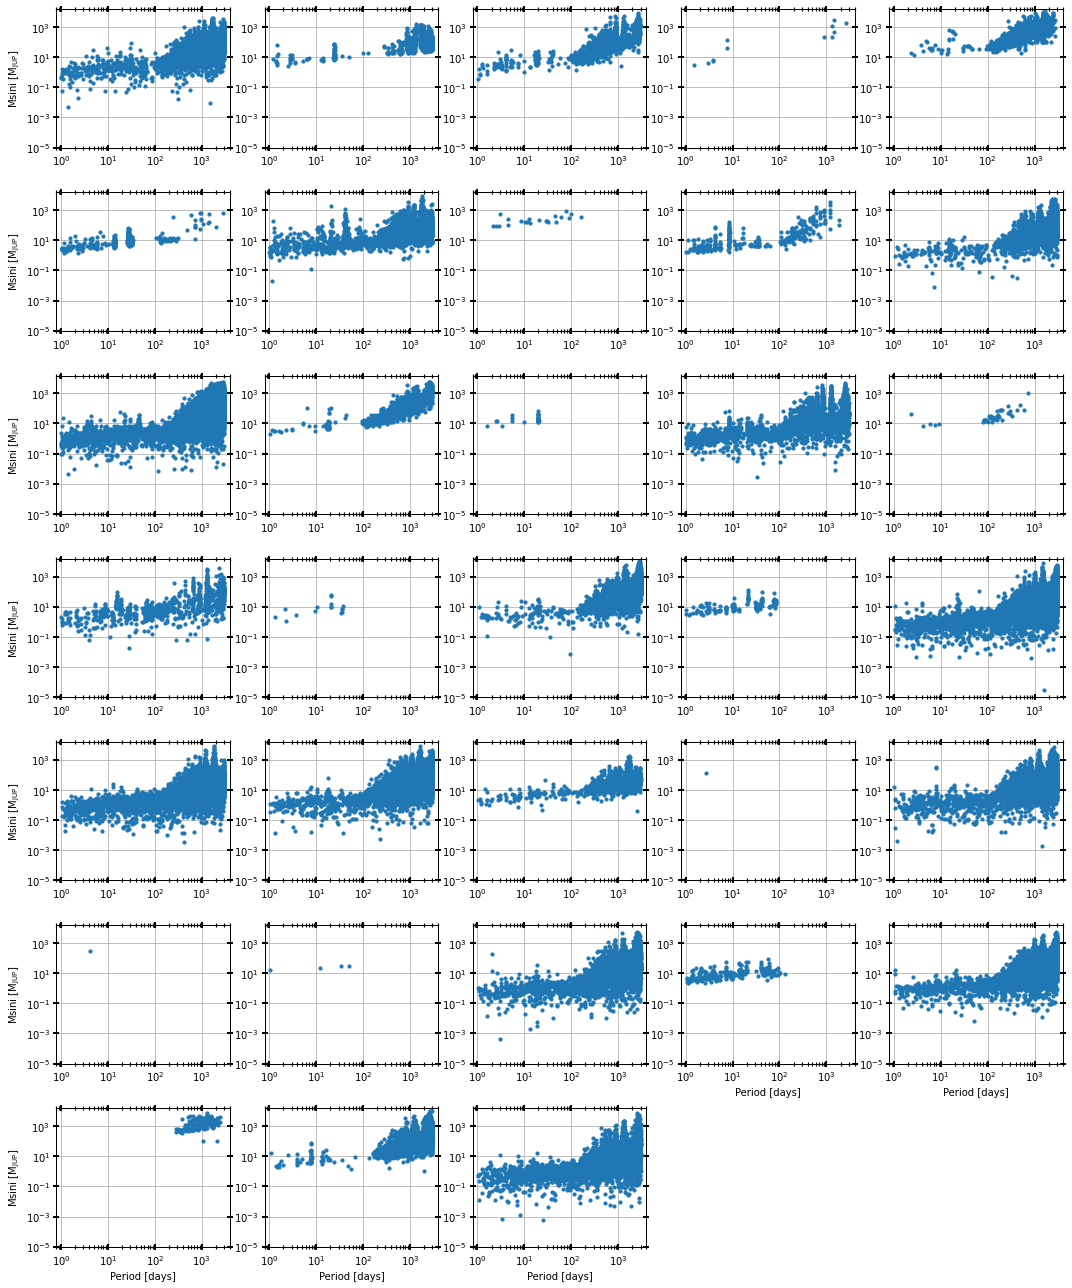

In [99]:
PLOT_PARAMS(LS=10, SIZE=10)
plt.figure(figsize=(15,18))
minP,maxP = 0.8, 4000
minM,maxM = 1e-5, 15000
c = 0
rows, cols = 7,5
for k, v in mjup_dir_112.items():
    plt.subplot(rows, cols,c+1)
    plt.scatter(v[0],v[1],s=10)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(minP,maxP)
    plt.ylim(minM,maxM)
    plt.grid()
    if c % 5 == 0:
        plt.ylabel(r'Msini [M$_{\rm JUP}$]')
    c+=1

for k, v in mjup_dir_113.items():
    plt.subplot(rows, cols,c+1)
    plt.scatter(v[0],v[1],s=10)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(minP,maxP)
    plt.ylim(minM,maxM)
    plt.grid()
    if c % 5 == 0:
        plt.ylabel(r'Msini [M$_{\rm JUP}$]')
    if c+1 > 28:
        plt.xlabel('Period [days]')
    c+=1
    
plt.tight_layout()
plt.subplots_adjust(wspace=0.2)
# plt.savefig('../plots/P_vs_Msini_%s.png'%DATE,bbox_inches='tight',dpi=150)


In [ ]:
binary_list_113

In [ ]:
table4[table4.Mj50<100].vbroad
rv_df.logg

In [ ]:
all_epsilon = np.concatenate([epsilon_113,epsilon_112])
bins =np.logspace(-9,np.log10(4),10)

_=plt.hist(all_epsilon,bins=bins)
plt.xscale('log')
plt.axvline(np.nanmedian(all_epsilon),c='r')
print(np.nanmedian(all_epsilon),np.nanmin(all_epsilon),np.nanmax(all_epsilon))

In [ ]:
ss

In [ ]:
PLOT_PARAMS(LS=14, SIZE=12)
plt.figure(figsize=(6,5))
ax=plt.subplot(111)
uni_modal_ids = [16,18]
xvals, yvals, yerr = [],[], []
c=0
idx  = []
uidx = []
for k,v in epsilon_dir_113.items():
    li_val = rv_df[(rv_df.program==113) & (rv_df.RG_id==k)].vbroad.values[0]
    v16, v50, v84 = np.percentile(v, 16), np.percentile(v, 50), np.percentile(v, 84)
    #print(v16, v50, v84)
    mean_eps, std_eps = np.nanmean(v),np.nanstd(v)
    
    xvals.append(li_val)
    yvals.append(v50)
    yerr.append(np.array([v16, v84]))
    if k in binary_list_113:
        idx.append(c)
    if k in uni_modal_ids:
        uidx.append(c)
    c+=1

idx = np.array(idx)
xvals, yvals, yerr = np.array(xvals), np.array(yvals), np.array(yerr)
yerr1 = -(yerr[:,0] - yvals)
yerr2 = yerr[:,1] - yvals


plt.errorbar(xvals, yvals, fmt='o',yerr=[yerr1,yerr2],capsize=2,lw=1, label='ESPRESSO Targets',color='grey')
plt.errorbar(xvals[idx], yvals[idx], fmt='o',yerr=[yerr1[idx],yerr2[idx]],capsize=2,lw=1,c='firebrick',label='Binary Candidates')
plt.scatter(xvals[uidx], yvals[uidx], ec='k', fc='None', s=200,label='Uni-Modal')

xvals, yvals, yerr = [],[], []
c=0
idx = []
for k,v in epsilon_dir_112.items():
    li_val = rv_df[(rv_df.program==112) & (rv_df.RG_id==k)].vbroad.values[0]
    v16, v50, v84 = np.percentile(v, 16), np.percentile(v, 50), np.percentile(v, 84)
    xvals.append(li_val)
    yvals.append(v50)
    yerr.append(np.array([v16, v84]))
    if k in binary_list_112:
        idx.append(c)
    c+=1
idx = np.array(idx)
xvals, yvals, yerr = np.array(xvals), np.array(yvals), np.array(yerr)
yerr1 = -(yerr[:,0] - yvals)
yerr2 = yerr[:,1] - yvals

plt.errorbar(xvals, yvals, fmt='o',yerr=[yerr1,yerr2],capsize=2,lw=1, color='grey')
plt.errorbar(xvals[idx], yvals[idx], fmt='o',yerr=[yerr1[idx],yerr2[idx]],capsize=2,lw=1,c='firebrick')
plt.yscale('log')

plt.legend()
plt.xlabel(r'v$_{broad}$ [km/s]')
plt.ylabel('Tidal Parameter, $\epsilon$')

ax.legend(bbox_to_anchor=(0., 1.25), loc='upper left', ncol=2,fontsize=12)
plt.tight_layout()
# plt.savefig('../plots/epsilon_%s.png'%DATE,bbox_inches='tight',dpi=200)


In [ ]:
ss

In [ ]:
print((1125.963451-840.978220)*u.Mjup.to(u.Msun))
print((840.978220-617.001644)*u.Mjup.to(u.Msun))
print(840.978220*u.Mjup.to(u.Msun))
# print(5.178447-4.216385)
# 
# 0.550991-0.504116#,
# 0.591811-0.550991

In [ ]:
np.sort(table4.Mj50*u.Mjup)

In [ ]:

def stats():
    xx = pd.merge(rv_df, galah_vac, left_on='sobject_id',right_on='sobject_id')
    mass_full = xx.m_act_bstep.to_numpy()
    mass_bin  = table4.m_act_bstep.to_numpy()
    
    vbr_full = rv_df.vbroad.to_numpy()
    vbr_bin = table4.vbroad.to_numpy()
    plt.figure(figsize=(5,4))
    bins = np.arange(5,52,3)
    a1=plt.hist(vbr_full,bins=bins)
    a2=plt.hist(vbr_bin,bins=bins)
    plt.xlabel('vbroad')
    print('binary vbroad:',min(vbr_bin),max(vbr_bin))
    print('full target vbroad:',min(vbr_full),max(vbr_full))

    print('vbr<10:',len(vbr_full[vbr_full<=10]),len(vbr_bin[vbr_bin<=10]))
    print('vbr>10:',len(vbr_full[vbr_full>10]),len(vbr_bin[vbr_bin>10]))
    
    
    plt.figure(figsize=(5,4))
    bins = np.arange(0,4,0.5)
    a1=plt.hist(mass_full,bins=bins)
    a2=plt.hist(mass_bin,bins=bins)
    print('binary mass:',min(mass_bin),max(mass_bin))
    print('full target mass:',min(mass_full),max(mass_full))
    plt.xlabel('stellar mass')
    
    logg_full = rv_df.logg.to_numpy()
    logg_bin  = table4.logg.to_numpy()
    N1 = len(logg_full[(logg_full>=2.0) & (logg_full<=3.0)])
    N2 = len(logg_bin[(logg_bin>=2.0) & (logg_bin<=3.0)])
    print(N1,N2,len(logg_full))
    
    plt.figure(figsize=(5,4))
    bins = np.arange(0,5,0.5)
    plt.hist(logg_full,bins=bins)
    plt.hist(logg_bin,bins=bins)
    plt.xlabel('logg')
    
    binary = rv_df[rv_df.sobject_id.isin(table4.sobject_id)]
    notbin = rv_df[~rv_df.sobject_id.isin(table4.sobject_id)]
    nb_logg = notbin.logg.values
    b_logg  = binary.logg.values
    print('non binaries between 2.5-3:',len(nb_logg[(nb_logg>=2.5) & (nb_logg<=3.0)]))
    print('non binaries smaller than 2.5:',len(nb_logg[(nb_logg<=2.5)]))
    
    return table4[table4.Li_val>2.5][['Mj50','vbroad','logg','program','RG_id','K50','Li_val','m_act_bstep']]#.vbroad.tolist()

stats()


In [ ]:
def wd_eq1(mf):
    'from cummings 2024 ? cunningham?????'
    return (mf-0.469)/0.086
def wd_eq2(mf):
    'from cummings 2024'
    return (mf-0.40)/0.1
def wd_eq3(mf):
    'from cummings 2024'
    return (mf-0.57)/0.06
def wd_eq4(mf):
    'from cummings 2024'
    return (mf-0.04)/0.17
def wd_eq4b(mf):
    'from cummings 2024'
    return (mf+0.04)/0.15

print(wd_eq1(0.6),wd_eq2(0.6),wd_eq3(0.6),wd_eq4(0.6),wd_eq4b(0.6))
print(wd_eq1(0.8),wd_eq2(0.8),wd_eq3(0.8),wd_eq4(0.8),wd_eq4b(0.8))

In [ ]:
stellar_masses_mjup = table4[table4.Mj50>100].Mj50.tolist()
stellar_masses_msun = np.array([i*u.Mjup.to(u.Msun) for i in stellar_masses_mjup])


In [ ]:

print('masses 3.6-7.2:')

def wd_eq(mf):
    '''from Cummings2018, eq 6'''
    return (mf-0.471)/0.107
print(wd_eq(0.6), wd_eq(0.8) )
print('final masses:')
print(stellar_masses_msun,'\n')

print('white dwarf initial mass with eq 6:')
print(wd_eq(stellar_masses_msun),'\n')

print('inflate final mass by 20% (Shahaf 2025):')
print(wd_eq(stellar_masses_msun*1.2),'\n')

print('inflate final mass by 75% after correcting for mass loss (Cummings2018) ')
print(wd_eq(stellar_masses_msun*1.75),'\n')

print('# inflate final mass by 85% after correcting for mass loss (Cummings2018) ')
print(wd_eq(stellar_masses_msun*1.85),'\n')
    

In [ ]:
ss

## can no longer make these plots:

In [ ]:

# a_all.v_max.to_numpy()[0].to(u.km/u.hour)
bounds = [1.5, 2.2, 3.2, 4, 4.3]
cmap_color = 'Reds'
cmap = plt.get_cmap(cmap_color, len(bounds))
norm = colors.BoundaryNorm(bounds, cmap.N)
clabel = 'A(Li)'

plt.figure(figsize=(8,3.5))
ax1=plt.subplot(121)
im1=plt.scatter(table3.vbroad, table3.v_orb, c=table3.Li_val, cmap=cmap, norm=norm,ec='grey')
plt.xlabel('v$_\mathrm{broad}$ [km/s]')

plt.ylabel('v$_\mathrm{orbit}$ [km/s]')

line=np.linspace(min(table3.vbroad),max(table3.vbroad),1000)
# plt.plot(line,line,c='k')

ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("top", size="7%", pad="2%") # add an axes above the main axes.
cb1 = fig.colorbar(im1, cax=cax1, orientation="horizontal", boundaries=bounds, ticks=bounds)
cax1.xaxis.set_ticks_position("top") # change tick position to top
cb1.ax.set_title(clabel)

ax2=plt.subplot(122)
im2=plt.scatter(table3[table3.v_max<1000].vbroad,table3[table3.v_max<1000].v_max, c=table3[table3.v_max<1000].Li_val, cmap=cmap, norm=norm,ec='grey')
plt.xlabel('v$_\mathrm{broad}$ [km/s]')
plt.ylabel('v$_\mathrm{max}$ [km/s]')

ax2_divider = make_axes_locatable(ax2)
cax2 = ax2_divider.append_axes("top", size="7%", pad="2%") # add an axes above the main axes.
cb2 = fig.colorbar(im2, cax=cax2, orientation="horizontal", boundaries=bounds, ticks=bounds)
cax2.xaxis.set_ticks_position("top") # change tick position to top
cb2.ax.set_title(clabel)

# ax2.set_xscale('log')
# ax2.set_yscale('log')


plt.tight_layout()
# plt.savefig('../plots/vbroad_vmax_vorb_%s.png'%DATE,bbox_inches='tight',dpi=200)
plt.show()

In [ ]:
bounds = [1.5, 2.2, 3.2, 4, 5.0]
cmap_color = 'Reds'
cmap = plt.get_cmap(cmap_color, len(bounds))
norm = colors.BoundaryNorm(bounds, cmap.N)
clabel = 'A(Li)'

fig=plt.figure(figsize=(6,4))
ax1=plt.subplot(111)
plt.errorbar(table3.e50, table3.P50,color='lightgrey', xerr=[table3.e50-table3.e16,table3.e84-table3.e50],
            yerr=[table3.P50-table3.P16,table3.P84-table3.P50],capsize=2, fmt='o',mec=None,mfc=None,zorder=-100,lw=1)

im1=plt.scatter(table3.e50, table3.P50, c=table3.Li_val,cmap=cmap, norm=norm,ec='grey')

ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("top", size="7%", pad="2%") # add an axes above the main axes.
cb1 = fig.colorbar(im1, cax=cax1, orientation="horizontal", boundaries=bounds, ticks=bounds)
cax1.xaxis.set_ticks_position("top") # change tick position to top
cb1.ax.set_title(clabel)

ax1.set_yscale('log')
ax1.set_xlabel('Eccentricity')
ax1.set_ylabel('Period [days]')
# plt.savefig('../plots/e_P_li_%s.png'%DATE,bbox_inches='tight',dpi=200)


In [ ]:

bounds = [1.5, 2.2, 3.2, 4, 5.0]
cmap_color = 'Reds'
cmap = plt.get_cmap(cmap_color, len(bounds))
norm = colors.BoundaryNorm(bounds, cmap.N)
clabel = 'A(Li)'

fig=plt.figure(figsize=(6,4))
ax1=plt.subplot(111)
plt.errorbar(table3.vbroad, table3.P50, xerr=table3.e_vbroad,
             yerr=[table3.P50-table3.P16,table3.P84-table3.P50],
             capsize=2, fmt='o',mec=None,mfc=None,zorder=-100,lw=1,color='lightgrey')

im1 = plt.scatter(table3.vbroad, table3.P50, c=table3.Li_val,cmap=cmap, norm=norm,ec='grey',s=60)

ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("top", size="7%", pad="2%") # add an axes above the main axes.
cb1 = fig.colorbar(im1, cax=cax1, orientation="horizontal", boundaries=bounds, ticks=bounds)
cax1.xaxis.set_ticks_position("top") # change tick position to top
cb1.ax.set_title(clabel)

ax1.set_yscale('log')
ax1.set_xscale('log')
xticks = [4, 10, 20,40, 60]
xlabels = ['%i' %x for x in xticks]
ax1.set_xticks(xticks)
ax1.set_xticklabels(xlabels)

ax1.set_xlabel('v$_{\mathrm{broad}}$ [km/s]')
ax1.set_ylabel('Period [days]')
ax1.grid(ls='dotted')

# ax1.set_ylim(25.44715063069063, 1858.443368942767)
# ax1.set_xlim(3.063198120106046, 61.2462833430784)
# plt.savefig('../plots/a1_%s.png'%DATE,bbox_inches='tight',dpi=200)


In [ ]:
bounds = [5,13,80,500,1100]
cmap_color = 'Reds'
cmap = plt.get_cmap(cmap_color, len(bounds))
norm = colors.BoundaryNorm(bounds, cmap.N)
clabel = 'M sini [M$_J$]'

fig=plt.figure(figsize=(6,4))
ax1=plt.subplot(111)
plt.errorbar(table3.vbroad, table3.P50, xerr=table3.e_vbroad,
             yerr=[table3.P50-table3.P16,table3.P84-table3.P50],
             capsize=2, fmt='o',mec=None,mfc=None,zorder=-100,lw=1,color='lightgrey')

im1=plt.scatter(table3.vbroad, table3.P50, c=table3.Mj50,cmap=cmap, norm=norm,ec='grey',s=60)

ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("top", size="7%", pad="2%") # add an axes above the main axes.
cb1 = fig.colorbar(im1, cax=cax1, orientation="horizontal", boundaries=bounds, ticks=bounds)
cax1.xaxis.set_ticks_position("top") # change tick position to top
cb1.ax.set_title(clabel)

ax1.set_yscale('log')
ax1.set_xscale('log')
xticks = [4, 10, 20,40, 60]
xlabels = ['%i' %x for x in xticks]
ax1.set_xticks(xticks)
ax1.set_xticklabels(xlabels)


ax1.set_xlabel('v$_{\mathrm{broad}}$ [km/s]')
ax1.set_ylabel('Period [days]')
ax1.grid(ls='dotted')
# ax1.set_ylim(25.44715063069063, 1858.443368942767)
# ax1.set_xlim(3.063198120106046, 61.2462833430784)

# plt.savefig('../plots/a2_%s.png'%DATE,bbox_inches='tight',dpi=200)


In [ ]:
PLOT_PARAMS()
bounds = [4,10,20,40,60]
cmap_color = 'Reds'
cmap = plt.get_cmap(cmap_color, len(bounds))
norm = colors.BoundaryNorm(bounds, cmap.N)
clabel = 'v$_{\mathrm{broad}}$ [km/s]'
print

real_size  = table3.Mj50.to_numpy()
mask0 = (real_size < 13)
mask1 = ((real_size >= 13) & (real_size < 80))
mask2 = ((real_size >= 0.08*msolar) & (real_size < 0.6*msolar))
mask3 = (real_size >= 0.6*msolar)

dummy_size = np.zeros(len(real_size))
dummy_size[mask0] = 30
dummy_size[mask1] = 80
dummy_size[mask2] = 300
dummy_size[mask3] = 700

plt.figure(figsize=(6,4))

ax=plt.subplot(111)
im = plt.scatter(table3.Li_val, table3.P50, s= dummy_size,ec='k', c=table3.vbroad,cmap=cmap,norm=norm)
plt.scatter(table3[mask0].Li_val, table3[mask0].P50, s= dummy_size[mask0],ec='k', c=table3[mask0].vbroad,cmap=cmap,norm=norm)
lgnd = [Line2D([0], [0], marker='o', mec='k',mfc=cmap(0.25),ms=np.sqrt(30),ls='',label='$\mathrm{M \sin(i) < 13 \; M_J}$'), 
        Line2D([0], [0], marker='o', mec='k',mfc=cmap(0.25),ms=np.sqrt(80),ls='',label='$\mathrm{M \sin(i) = 13-80 \; M_J}$'), 
        Line2D([0], [0], marker='o', mec='k',mfc=cmap(0.25),ms=np.sqrt(300),ls='',label='$\mathrm{M \sin(i) = 0.08 - 0.6 \; M_\odot}$'), 
        Line2D([0], [0], marker='o', mec='k',mfc=cmap(0.25),ms=np.sqrt(700),ls='',label='$\mathrm{M \sin(i) > 0.6 \; M_\odot}$'), 
       ]
ax.legend(handles=lgnd,fontsize=12)

ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("top", size="7%", pad="2%") # add an axes above the main axes.
cb = fig.colorbar(im, cax=cax, orientation="horizontal", boundaries=bounds, ticks=bounds)
cax.xaxis.set_ticks_position("top") # change tick position to top
cb.ax.set_title(clabel)

ax.set_yscale('log')
ax.set_xlabel('A(Li) [dex]')
ax.set_ylabel('Period [days]')
plt.tight_layout()

# plt.savefig('../plots/p_vs_li_size_%s.png'%DATE,bbox_inches='tight',dpi=200)

In [ ]:
plt.figure(figsize=(6,4))
color='brown'
ax1=plt.subplot(111)
plt.errorbar(table3.vbroad, table3.P50, xerr=table3.e_vbroad,
             yerr=[table3.P50-table3.P16,table3.P84-table3.P50],
             fmt='o',c='grey',mfc=color,mec=color,capsize=2)#,c=table3.Ba_fe)
# plt.colorbar()
plt.xlabel('v$_{\mathrm{broad}}$ [km/s]')
plt.ylabel('Period [days]')
plt.yscale('log')
plt.xscale('log')

def func(x, m, b):
    
    return m*x + b

from scipy.optimize import curve_fit

xdata,ydata = table3.vbroad.to_numpy(), table3.P50.to_numpy()
mask = np.argsort(xdata)
xdata,ydata = xdata[mask],ydata[mask]
xlog, ylog = np.log10(xdata),np.log10(ydata)
popt, pcov = curve_fit(func, xlog, ylog)

xvals = np.log10(np.linspace(4, 60, 100))
xticks = [4, 10, 20,40, 60]
xlabels = ['%i' %x for x in xticks]
ax1.set_xticks(xticks)
ax1.set_xticklabels(xlabels)
plt.grid(ls='dotted')

plt.plot(10.**xvals, 10.**func(xvals, *popt), 'k-',
         label='log(P) = $%.1f*\log(v_{br}$) + %.1f' % tuple(popt))
# print(plt.ylim())
# print(plt.xlim())
plt.legend(loc='upper right')
plt.ylim(25.44715063069063, 1858.443368942767)
plt.xlim(3.063198120106046, 61.2462833430784)
# plt.savefig('../plots/b.png',bbox_inches='tight',dpi=200)

In [ ]:
plt.figure()
plt.scatter(table3.P50,table3.Mj50/(table3.m_act_bstep*u.Msun.to(u.Mjup)),)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Period [days]')
plt.ylabel('Mass ratio')
plt.xlim(1,1e5)
plt.ylim(0.004,1)
plt.axhline()

In [ ]:
PLOT_PARAMS()
plt.figure(figsize=(6,4))
bins=np.arange(0.5,4,0.5)
d1 = rv_df[(rv_df.program==112) & (rv_df.RG_id.isin(binary_list_112))]#.Li_val.values
d2 = rv_df[(rv_df.program==113) & (rv_df.RG_id.isin(binary_list_113))]#.Li_val.values
both_galah = pd.concat([d1, d2])

x1=plt.hist(rv_df.logg.values, bins=bins, label='Observed',color='lightgrey', ec='k')
# plt.hist(rv_df[(rv_df.program==112) & (rv_df.RG_id.isin(binary_list_112))].Li_val.values, bins=bins, label='Observed',color='lightgrey', ec='k')
x2=plt.hist(both_galah.logg.values, bins=bins, label='Binary',color='darkred', ec='k')
plt.xlabel('A(Li) [dex]')
plt.ylabel('Counts')
plt.legend()
# plt.savefig('../plots/logg_fraction_%s.png'%DATE,bbox_inches='tight',dpi=150)
print(x1[0])
print(x2[0])
print(x2[0]/x1[0])

In [ ]:
print(binary_list_112)
print(binary_list_113)


In [ ]:
ss

In [ ]:
# fig=plt.figure(figsize=(7,4),dpi=200)
# ax=plt.subplot(111)
# plot_joker_samples(rv_df, 13, program=112, ax=ax)

In [ ]:
# fig=plt.figure(figsize=(7,4),dpi=200)
# ax=plt.subplot(111)
# plot_joker_samples(rv_df, 18, program=113, ax=ax)

In [ ]:
# fig=plt.figure(figsize=(7,4),dpi=200)
# ax=plt.subplot(111)
# # plot_joker_samples(rv_df, 16, program=113, ax=ax)

In [ ]:
d1 = Table.read('../files/espresso_final_result.fits').to_pandas()
d2 = pd.merge(d1, table3, left_on='sobject_id',right_on='sobject_id')#.keys()
plt.figure()

plt.scatter(d2.logg_c, d2.logg_x)
plt.xlabel('Logg from Anne [dex]')
plt.ylabel('Logg from Galah [dex]')
line=np.linspace(min(d2.logg_c), max(d2.logg_c),1000)
plt.plot(line,line)
len(d2)

In [ ]:
table3[['RG_id','program','P50','e50','Li_val','vbroad','Mj50','a50','logg','m_act_bstep','K50','fe_h']].sort_values(by='Mj50')


In [ ]:
def get_k_amp(P, msini, Mstar, e):
    '''
    P     : in days
    Mstar : solar mass
    msini : jupiter mass
    e     : dimensionless
    
    '''
    P = (P*u.day).to(u.second)
    msini = (msini*u.Mjup).to(u.kg)
    Mstar = (Mstar*u.M_sun).to(u.kg)
    e = e*u.dimensionless_unscaled
   
    # define constants
    pi = np.pi
    G  = const.G
    
    K = msini/((P/(2*pi*G))**(1./3)*(Mstar+msini)**(2./3)*(1-e)**0.5)
    
    K = K.to(u.km/u.s)
    
    return K.value


In [ ]:
a  = np.array([[1.,2.,3.],[4.,5.,6.]])
a += np.array([[np.nan,2.,3.],[4.,5.,6.]])
a

In [ ]:
mdwarf_low, mdwarf_up = 0.08*msolar, 0.6*msolar
Pvals      = np.logspace(0, 3.5, 1000)
msini_vals = np.logspace(0, 3, 1000)#np.log10(mdwarf_low), np.log10(mdwarf_up), 1000)

Ms,Ps = np.meshgrid(msini_vals,Pvals)
from matplotlib.colors import LogNorm


d1tempa = rv_df[(rv_df.program==113) & (~rv_df.RG_id.isin(binary_list_113))]
d1tempb = rv_df[(rv_df.program==112) & (~rv_df.RG_id.isin(binary_list_112))]
d1temp  = pd.concat([d1tempa, d1tempb])
d1temp  = pd.merge(d1temp, galah_vac[['sobject_id','m_act_bstep','e_m_act_bstep','radius_bstep','e_radius_bstep']], left_on='galah_id',right_on='sobject_id')
d1temp  = d1temp[d1temp.sobject_id_x!=190212001601338] # YSO removed from sample

def non_binary_msini(df,ecc,axes):
    non_binary_d = {'sobject_id':[],'Klim':[],'max_msini':[], }
    fig  = plt.figure(figsize=(8,15))
    PLOT_PARAMS(SIZE=10,LS=10)
    summed_Ks = np.zeros_like(Ms)

    for j,star in enumerate(df.galah_id.to_numpy()):
        d2temp      = d1temp[d1temp.galah_id==star]#.m_act_bs
        Mstar       = d2temp.m_act_bstep.values[0]
        _,rv_vals,_ = clean_up(d2temp)
        Klim  = max(rv_vals)-min(rv_vals)
        Kvals = get_k_amp(Ps, Ms, Mstar, e=ecc)
        
        mask  = (Kvals > Klim)
        Kvals[mask] = np.nan

        #print(star,Mstar, Klim,)
        # plt.imshow(Kvals,origin='lower',extent=[Pvals[0], Pvals[-1], msini_vals[0], msini_vals[-1]],aspect='auto')

        ax   = plt.subplot(6,3,j+1)
        
        mesh = ax.pcolormesh(Ps, Ms, Kvals, cmap='Reds')
        
        Kvals_zeros = np.copy(Kvals)
        Kvals_zeros[np.isnan(Kvals_zeros)] = 0
        
        summed_Ks += Kvals_zeros
        
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('Period [days]')
        ax.set_ylabel(r'M$\sin(i)$ [M$_{\rm Jup}$]')
        ax.text(0.95, 0.95, s=star, transform=ax.transAxes,fontsize=10, ha='right',va='top')
        # Add a colorbar
        #fig.colorbar(mesh, ax=ax,label='K-amplitude')
        try:
            max_index_flat = np.nanargmax(Kvals)
            # Convert the flat index to 2D coordinates
            max_index_2d = np.unravel_index(max_index_flat, Kvals.shape)
            index_of_Ps, index_of_Ms  = max_index_2d
            #plt.scatter(msini_vals[index_of_Ms], Pvals[index_of_Ps],c='lightgreen',s=70)
            max_msini = msini_vals[index_of_Ms]
        except Exception as e:
            max_msini = np.nan

        ax_divider = make_axes_locatable(ax)
        cax = ax_divider.append_axes("top", size="7%", pad="2%") # add an axes above the main axes.
        cb = fig.colorbar(mesh, cax=cax, orientation="horizontal")
        cax.xaxis.set_ticks_position("top") # change tick position to top
        cb.ax.set_title('K')

        non_binary_d['sobject_id'].append(star)
        non_binary_d['Klim'].append(Klim)
        non_binary_d['max_msini'].append(max_msini)
        
    plt.tight_layout()
    plt.close()
    PLOT_PARAMS(SIZE=12, LS=12)
    axes.set_xscale('log')
    axes.set_yscale('log')
    axes.set_xlabel('Period [days]')
    axes.set_ylabel(r'M$\sin(i)$ [M$_{\rm Jup}$]')
    axes.text(0.05, 0.95, s=r'$e = $ %.1f'%ecc, transform=axes.transAxes,fontsize=14, ha='left',va='top')

    summed_Ks[(summed_Ks == 0.)] = np.nan

    mesh = axes.pcolormesh(Ps, Ms, summed_Ks, cmap='Reds',vmin=0.2,vmax=3.0)
    
    ax_divider = make_axes_locatable(axes)
    cax = ax_divider.append_axes("top", size="7%", pad="2%") # add an axes above the main axes.
    cb = fig.colorbar(mesh, cax=cax, orientation="horizontal")
    cax.xaxis.set_ticks_position("top") # change tick position to top
    cb.ax.set_title('Semi-amplitude [km/s]')
    axes.grid(which='both',color='lightgrey',ls='dotted')
    non_binary_d = pd.DataFrame(non_binary_d)
    
    return non_binary_d
PLOT_PARAMS(SIZE=14, LS=14)
fig = plt.figure(figsize=(12,4))  
ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)
non_binary_d = non_binary_msini(d1temp,ecc=0.0,axes=ax1)
non_binary_d = non_binary_msini(d1temp,ecc=0.5,axes=ax2)
non_binary_d = non_binary_msini(d1temp,ecc=0.9,axes=ax3)
plt.tight_layout()
plt.savefig('../plots/M_vs_P_%s.png'%DATE, bbox_inches='tight',dpi=150)
plt.show()
    

In [ ]:
ss

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(4,5))
# ax1.hist(non_binary_d[non_binary_d.e_val==0].max_msini,bins='auto', color='lightsalmon',ec='k')
# ax2.hist(non_binary_d[non_binary_d.e_val==0.50].max_msini,bins='auto',color='lightsalmon',ec='k')
# ax3.hist(non_binary_d[non_binary_d.e_val==0.99].max_msini,bins='auto',color='lightsalmon',ec='k')

for ax, ecc in zip([ax1, ax2, ax3], [0,0.5,0.99]):
    ax.text(0.95, 0.95, s='e=%.2f'%ecc, transform=ax.transAxes,fontsize=14, ha='right',va='top')
    ax.set_ylabel('Counts')

for ax, ecc, y in zip([ax1, ax2, ax3], [0,0.50,0.99], [8, 4, 7]):
    ax.hist(non_binary_d[non_binary_d.e_val==ecc].max_msini,bins='auto', color='lightsalmon',ec='k')
    mean = np.mean(non_binary_d[non_binary_d.e_val==ecc].max_msini)
    ax.axvline(mean, c='k',ls='dashed')
    ax.text(mean, y, '$\mathrm{%.1f \; M_{Jup}}$' %mean, ha='left', va='top')
    
ax3.set_xlabel('$\mathrm{M\sin{i} \; [M_{Jup}]}$')
plt.tight_layout()

# plt.savefig('../plots/non_binary_max_msini_%s.png'%DATE,bbox_inches='tight',dpi=200)

In [ ]:
rv_df[rv_df.galah_id==170416004301008][['program','RG_id','Li_val']] #113 - 5
rv_df[rv_df.galah_id==140311007101261][['program','RG_id','Li_val']] #113 - 5

# 140806001701013,170602003701360, 161013005401317,140311007101261

In [ ]:
_,x,_=clean_up(rv_df[(rv_df.program==113) & (rv_df.RG_id==5)])
max(x)-min(x)

In [ ]:
def plot_ti(df):
    d1 = pd.read_csv('../../lithium/final_paper_sample_09_18.csv')[['galah_rich_id','galah_poor_id']]
    
    # this star below wasn't in the final sample of stars-doppelgagngers from 09_18 but it was there in the 
    # earlier version of this file which is when P112 was submitted. So I added it back.
    d2 = pd.DataFrame({'galah_rich_id':[160129003601260],'galah_poor_id':[151008001601006]})
    
    d1 = pd.concat([d1,d2])
    df = pd.merge(df, d1, left_on='sobject_id', right_on='galah_rich_id',how='left')
    
    d2 = {'rich':[], 'poor':[], 'Ti_fe_r':[], 'e_Ti_fe_r':[], 'Ti_fe_p':[], 'e_Ti_fe_p':[]}
    
    for i, row in df.iterrows():
        rich_id, poor_id = row.sobject_id, row.galah_poor_id
        Ti_fe_r, e_Ti_fe_r, flag_r = galah[galah.sobject_id==rich_id][['Ti_fe','e_Ti_fe','flag_Ti_fe']].values[0]
        Ti_fe_p, e_Ti_fe_p, flag_p = galah[galah.sobject_id==poor_id][['Ti_fe','e_Ti_fe','flag_Ti_fe']].values[0]
        #print(rich_id,Ti_fe_r, e_Ti_fe_r, Ti_fe_p, e_Ti_fe_p,flag_r,flag_p)
        d2['rich'].append(rich_id)
        d2['poor'].append(rich_id)
        d2['Ti_fe_r'].append(Ti_fe_r)
        d2['e_Ti_fe_r'].append(e_Ti_fe_r)
        d2['Ti_fe_p'].append(Ti_fe_p)
        d2['e_Ti_fe_p'].append(e_Ti_fe_p)
    d2=pd.DataFrame(d2)
#     print(d2)
    df=pd.merge(df, d2, left_on='galah_rich_id',right_on='rich')
    plt.scatter(df.Mj50, df.Li_val, fc='lightgrey',ec='grey')
    plt.scatter(df.Mj50, df.Li_val, c=df.Ti_fe_r-df.Ti_fe_p)
    plt.colorbar()
    return df[['Ti_fe_r','rich','Li_val']]

plot_ti(table3)



In [ ]:
ss

In [ ]:
'V_fe' in galah.keys()

In [ ]:
galah[galah.sobject_id==160521004801082][['Ti_fe','flag_Ti_fe']]

In [ ]:
rv_df[rv_df.sobject_id==160129003601260]
galah[galah.sobject_id==160129003601260][['fe_h','Li_fe']]


d1 = pd.read_csv('../../lithium/final_paper_sample_05_16.csv')[['galah_rich_id','galah_poor_id']]
d1[d1.galah_rich_id == 160129003601260]
# table3[table3.sobject_id==160129003601260].program
# pd.read_pickle('../../lithium/data/gfinal_rich.pkl')

In [ ]:
galah.Ti_fe
-0.213539+1.7660